In our setting, a scoring model generates scores to identify individuals who benefit the most from treatment. This notebook provides an example where we apply a correction to the scoring model and compare it with a causal-effect model learned from experimental data. 

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("..")
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import copy
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV, train_test_split

# Causal tree
from deconfounder.causal_tree import CausalTree

# Deconfounder
from deconfounder.deconfound_estimator import DeconfoundEstimator
from deconfounder.deconfound_classifier import DeconfoundClassifier
from deconfounder.deconfound_ranker import DeconfoundRanker

# Evaluation metrics
from metrics import mean_squared_error, causal_impact, auuc_score, uplift_curve

In [2]:
## Data generation functions

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def array_with_same_sign(arr):
    '''
    Return: an array with a uniform random distribution, where each element shares 
    the same sign as the corresponding element in the input array.
    '''
    k = len(arr)
    m = (arr >= 0)
    new_arr = m * np.random.uniform(0, 1, size=k) + (~m) * np.random.uniform(-1, 0, size=k)
    return new_arr

def array_with_same_order(arr):
    '''
    Return: an array with a uniform random distribution, where the elements maintain 
    the same order as in the input array.
    '''
    k = len(arr)
    m = (arr >= 0)
    order = np.argsort(arr)
    rank = np.argsort(order)
    new_arr_pos = np.sort(np.random.uniform(0, 1, size=k))[rank]
    new_arr_neg = np.sort(np.random.uniform(-1, 0, size=k))[rank]
    new_arr = m * new_arr_pos + (~m) * new_arr_neg

    # assert(np.array_equal(np.argsort(arr[m]), np.argsort(new_arr[m])))
    # assert(np.array_equal(np.argsort(arr[~m]), np.argsort(new_arr[~m])))

    return new_arr

class DataGenerator:
    '''
    - n_features: Number of features
    - keep_order: If True, the alpha array keeps the same order as beta; Otherwise alpha
      has the same sign as beta.
    - alpha_0: coefficient of u for y0, adjust confounding strength
    - noise_scale_eff: standard deviation of noise for treatment effect
    - noise_scale_yc: standard deviation of noise for controlled outcome
    '''

    def __init__(
        self, 
        n_features, 
        keep_order=False, 
        alpha_0 = 1.0,
        noise_scale_eff=0.0, 
        noise_scale_yc=0.0
    ):
        
        self.n_features = n_features
        self.keep_order = keep_order
        self.alpha_0 = alpha_0
        self.noise_scale_eff = noise_scale_eff
        self.noise_scale_yc = noise_scale_yc

    def reset_coef(self):
        '''
        Return:
            - beta: Coefficient of X for treatment effect
            - alpha: Coeficient of u for X.
            - theta: Coefficient of X for yc.
        '''
        k = self.n_features
        
        beta = np.random.uniform(-1, 1, size=k)     
        if self.keep_order:
            alpha = array_with_same_order(beta)
        else:
            alpha = array_with_same_sign(beta)  
        # theta = array_with_same_sign(alpha) 
        theta = np.zeros(shape=k)

        self.beta = beta
        self.alpha = alpha
        self.theta = theta

    def treatment_effect(self, X):

        beta = self.beta
        beta_0 = 0
        x_beta = np.squeeze(np.dot(X, beta[:, np.newaxis]))
        eff = x_beta + beta_0
        return eff

    def controlled_outcome(self, X, u):

        theta = self.theta
        alpha_0 = self.alpha_0
        noise_scale = self.noise_scale_yc
        noise_yc = np.random.normal(0, noise_scale, size=X.shape[0])
        x_theta = np.squeeze(np.dot(X, theta[:, np.newaxis]))
        yc = x_theta + u * alpha_0 + noise_yc
        return yc

    def generate_data(self, n, is_exp=True):

        k = self.n_features
        noise_scale_eff = self.noise_scale_eff

        u = np.random.uniform(0, 1, size=n) 
        p = sigmoid(np.dot(u[:, np.newaxis], self.alpha[np.newaxis, :]))
        X = np.random.binomial(1, p=p, size=(n, k))

        # treatment effect
        eff = self.treatment_effect(X)
        noise_eff = np.random.normal(0, noise_scale_eff, size=n)

        # controlled outcome
        yc = self.controlled_outcome(X, u)

        if is_exp:
            p_t = 0.5
        else:
            p_t = u.copy()
        t = np.random.binomial(1, p=p_t, size=n)
        y = yc + (eff + noise_eff) * t

        return X, t, y, eff, yc
    
def power2(min_num, max_num, scaler=1):

    grid = []
    num = scaler
    while num < min_num:
        num *= 2
    while num < max_num:
        grid.append(num)
        num *= 2
    return grid


The confounded data is simulated, and the diagram below illustrates the relationships among the variables. Here, X represents the features, T represents the treatment, Eff is the treatment effect, Yc is the controlled outcome, and U represents the unobserved confounder. U correlates with both T and Yc, leading to confounding. Meanwhile, U correlates with X, which can disrupt rankings.

```
T
|
U —— X —— Eff
|
Yc
```

In [3]:
seed = 42
np.random.seed(seed)

dg = DataGenerator(
    n_features=150,
    keep_order=False,
    alpha_0=5.0,
    noise_scale_eff=1.0,
    noise_scale_yc=0.1
)

dg.reset_coef()

## Observational data
n_obs = 50000
X_obs, t_obs, y_obs, eff_obs, yc_obs = dg.generate_data(n_obs, is_exp=False)

## Test data (experimental data)
n_test = 10000
X_test, t_test, y_test, eff_test, yc_test = dg.generate_data(n_test, is_exp=True)


Considering two scenarios:
* There is a large amoung of confounded observational data; 
* Only controlled data is available.

Two scoring models for the scenarios respectively: 
* A causal-effect model on the confounded data; 
* A predictive model on the controlled outcome.

In [4]:
def evaluate(eff_true, y_true, scores, treatment):

    mse = mean_squared_error(eff_true, scores)
    auuc = auuc_score(y_true, scores, treatment)
    decisions = (scores > 0)
    causal_imp = causal_impact(eff_true, decisions)

    return mse, causal_imp, auuc

In [5]:
res_sm = []

# Causal tree on confounded data
sm_cate = CausalTree(random_state=seed, min_samples_leaf=100)
sm_cate.fit(X_obs, np.c_[t_obs, y_obs])
conf_cate = sm_cate.predict(X_test)

mse, causal_imp, auuc = evaluate(eff_test, y_test, conf_cate, t_test)
res_sm.append({'target': 'conf_cate', 'mse': mse, 'causal_imp': causal_imp, 'auuc': auuc})

# Decision tree for yc 
sm_yc = DecisionTreeRegressor(random_state=seed, min_samples_leaf=100)
sm_yc.fit(X_obs, yc_obs)
yc_pred = sm_yc.predict(X_test)
res_sm.append({'target': 'yc', 'mse': mse, 'causal_imp': causal_imp, 'auuc': auuc})

res_df = pd.DataFrame(res_sm)
res_df.to_csv(f"../results/obs/scoring_model.csv", index=False)


Both scoring models perform better than the ATE, but there is still room for improvement compared to the true effects

In [6]:
## Plots
def plot_uplift_curves(y, t, scores_dict, n_bins=100):

    n = y.shape[0]
    y, t = np.array(y), np.array(t)
    ate = y[t==1].mean() - y[t==0].mean()
    plt.plot([0, n], [0, ate*n], label='Random')

    for label, scores in scores_dict.items():
        curve_values = uplift_curve(y, scores, t, n_bins)
        plt.plot(curve_values[0], curve_values[1], label=label)

    plt.xlabel('Numer of targeted')
    plt.ylabel("Increment")
    plt.legend()
    plt.show()

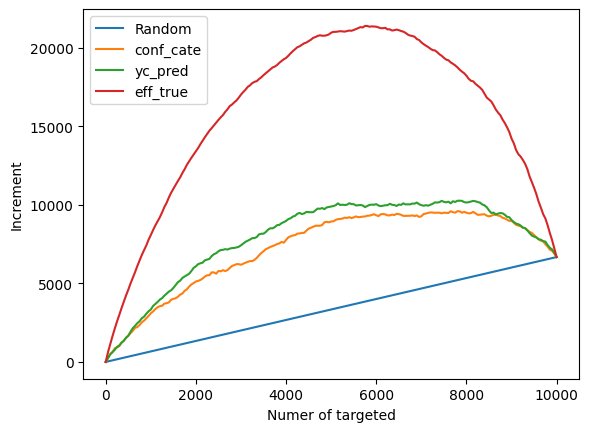

In [7]:
# Scoring model
scores_dict = {
    'conf_cate': conf_cate, 
    'yc_pred': yc_pred,
    'eff_true': eff_test
}

plot_uplift_curves(y_test, t_test, scores_dict, n_bins=200)


Deconfounders are built on scores and learn from the experimental data to predict corrections. There are three types of deconfounders, each with distinct optimization objective: (1) effect estimation (EE); (2) effect classification (EC); (3) effect ordering (EO). 

We compare the performance of deconfounders to a causal effect model that is learned from scratch using the experimental data. We vary the experimental data size and repeat experiments with different random seeds.

Three evaluation metrics:
* MSE of the treatment effects. $E[(c_i-\hat{c_i})^2]$
* Causal impact: $P(d=1)\cdot E(c|d=1)$, $d_i = [score_i>0]$
* AUUC (Area Under Uplift Curve): $\int_0^1{q\cdot V(q)}dq$, $V(q)=E[y_i(1)-y_i(0)|F_S(S(x_i))\geq 1-q]$, where $q$ is the fraction of samples treated, $F_S$ is the CDF of S(x) (scoring function).

In [8]:
def fit_causal_tree(X, t, y, tune=False, cv=5, seed=42, n_jobs=1):
    
    n = X.shape[0]
    model = CausalTree(random_state=seed)
    if tune:
        param_grid = {'min_samples_leaf': power2(16, n)}
        model_grid = GridSearchCV(model, param_grid, cv=cv, n_jobs=n_jobs)
        model_grid.fit(X, np.c_[t, y])
        # print("Best parameter:", model_grid.best_params_)
        model = model_grid.best_estimator_
    else:
        model.min_samples_leaf = min(100, int(0.1*n))
        model.fit(X, np.c_[t, y])
    return model

dcf_dict = {
    'EE': DeconfoundEstimator(),
    'EC': DeconfoundClassifier(),
    'EO': DeconfoundRanker(n_trees=10, n_levels=10, max_buckets=0.1,\
                           subsample=1, max_features=0.5)
}

def fit_deconfounder(X, t, y, scores, method='EE', tune=False, 
        cv=5, seed=42, n_jobs=1):

    n = X.shape[0]
    model = copy(dcf_dict[method])
    model.random_state = seed
    if tune:
        param_grid = {'min_samples_leaf': power2(16, n)}
        model_grid = GridSearchCV(model, param_grid, cv=cv, n_jobs=n_jobs)
        model_grid.fit(X, np.c_[t, y, scores])
        # print("Best parameter:", model_grid.best_params_)
        model = model_grid.best_estimator_
    else:
        model.min_samples_leaf = min(100, int(0.1*n))
        if method == 'EO':
            model.max_buckets = max(100, int(n * 0.1))
        model.fit(X, np.c_[t, y, scores])
    return model
    


In [9]:
dcf_types = ['EE', 'EC', 'EO']
targets = ['conf_cate', 'yc']

exp_size_grid = power2(100, 50000, scaler=100)

for seed in tqdm(range(20)):
    np.random.seed(seed)
    res = []
    for exp_size in exp_size_grid:
    
        # Generate data
        X_exp, t_exp, y_exp, eff_exp, yc_exp = dg.generate_data(exp_size, is_exp=True)

        # Causal tree
        ct = fit_causal_tree(X_exp, t_exp, y_exp, seed=seed)
        cate_pred = ct.predict(X_test)
        mse, causal_imp, auuc = evaluate(eff_test, y_test, cate_pred, t_test)
        res.append({'model': 'CT', 'exp_size': exp_size, 'mse': mse,'causal_imp': causal_imp, 'auuc': auuc})

        # Deconfounder
        for dcf_type in dcf_types:
            for target in targets:
                if target == 'conf_cate':
                    scores = sm_cate.predict(X_exp)
                    scores_test = conf_cate.copy()
                elif target == 'yc':
                    scores = sm_yc.predict(X_exp)
                    scores_test = yc_pred.copy()

                dm = fit_deconfounder(X_exp, t_exp, y_exp, scores, dcf_type, seed=seed)
                corrected_scores = scores_test - dm.predict(X_test)
                mse, causal_imp, auuc = evaluate(eff_test, y_test, corrected_scores, t_test)
                model_name = f"{target}+{dcf_type}"  
                res.append({'model': model_name, 'exp_size': exp_size, 'mse': mse, 'causal_imp': causal_imp, 'auuc': auuc})
    
    res_df = pd.DataFrame(res)
    res_df.to_csv(f"../results/exp/{seed}.csv", index=False)


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [09:07<00:00, 27.36s/it]


Experimental Results

In [10]:
res_sm = pd.read_csv("../results/obs/scoring_model.csv")

In [11]:
res_dir = "../results/exp"
res_df = pd.DataFrame()
for fname in os.listdir(res_dir):
    filepath = os.path.join(res_dir, fname)
    res_i = pd.read_csv(filepath)
    res_df = pd.concat([res_df, res_i])

res_df = res_df.groupby(by=['model', 'exp_size']).mean().reset_index()

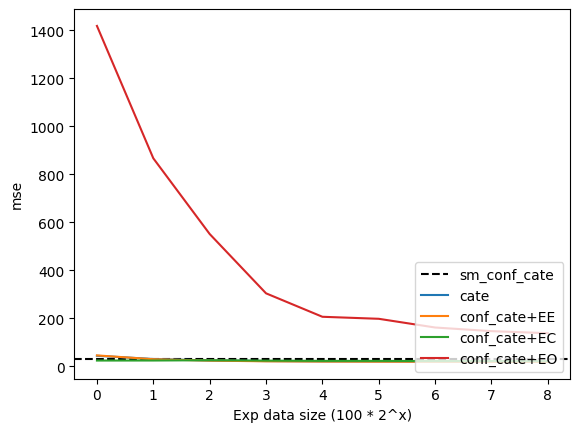

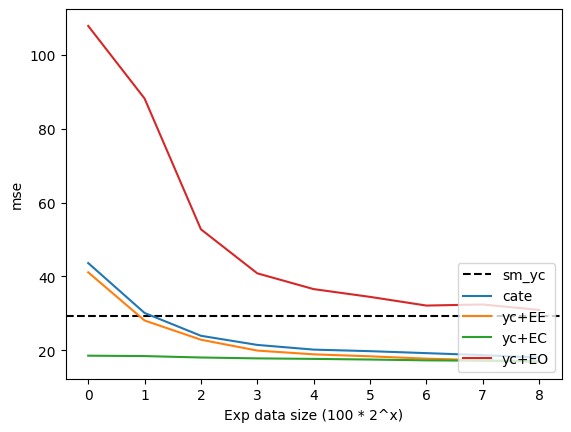

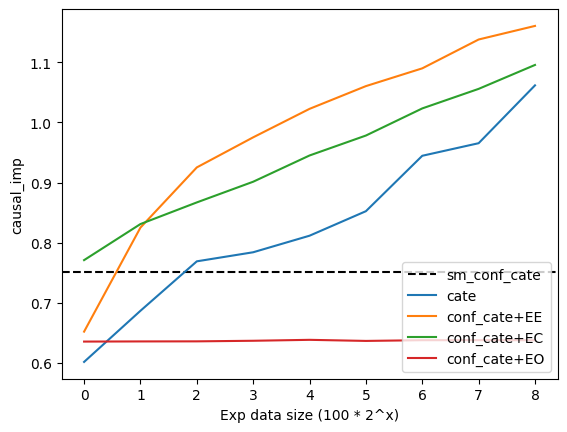

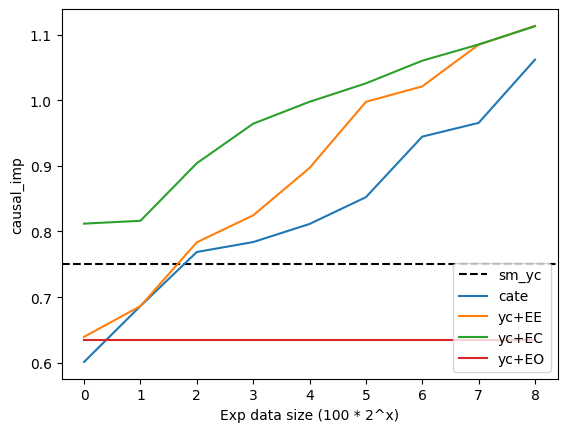

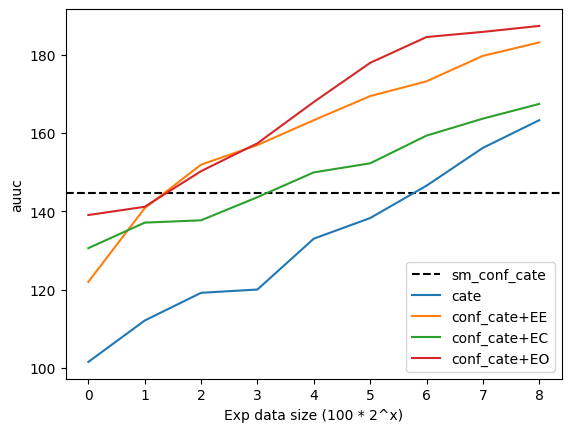

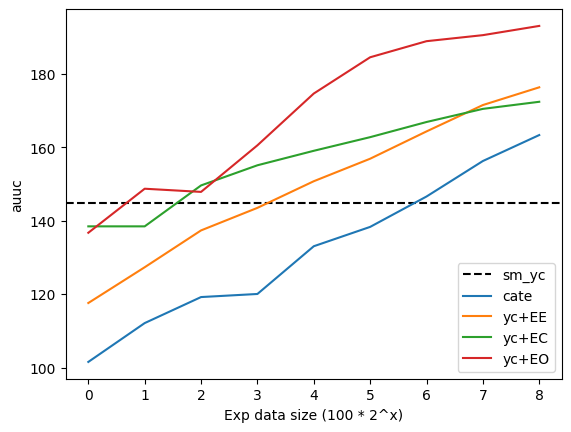

In [12]:
# Add a horizontal line
targets = ['conf_cate', 'yc']
dcf_types = ['EE', 'EC', 'EO']
metrics = ['mse', 'causal_imp', 'auuc']

for m in metrics:
    for target in targets:
        plt.axhline(y=res_sm.loc[res_sm.target==target, m].values[0], linestyle='--', color='black', label=f'sm_{target}')
        plt.plot(range(len(exp_size_grid)), res_df.loc[res_df.model=='CT', m], label='cate')
        for dcf_type in dcf_types:
            model_name = f"{target}+{dcf_type}" 
            plt.plot(range(len(exp_size_grid)), res_df.loc[res_df.model==model_name, m], label=model_name)
        plt.ylabel(m)
        plt.xlabel('Exp data size (100 * 2^x)')
        plt.legend(loc='lower right')
        plt.show()